In [32]:
#import files and libraries
import os
from PIL import Image, ImageOps, ImageEnhance
import numpy as np
import random


# Path to the dataset
path = r"C:\Users\asmun\OneDrive - NTNU\H24\Datadrevet\it3212-data-driven-software\datasets\r7bthvstxw-1"

# Function to collect image paths from the given directory
def images(path):
    found_images = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.jpg'):
                found_images.append(os.path.join(root, file))
    return found_images

found_im = images(path)



Need to augmentate pictures to expand dataset by rotating and doing things with the images

In [33]:
# Function to resize and augment images
def resize_and_augment_images(images, size, augment=True):
    processed_images = []
    for image in images:
        img = Image.open(image).convert('RGB')  # Greyscale
        img = img.resize((size, size))  # Resize to specified size
        
        if augment:  # Apply augmentation if enabled
            if random.random() > 0.5:  # Random rotation
                angle = random.randint(-30, 30)  # Rotate between -30 and 30 degrees
                img = img.rotate(angle)
            
            if random.random() > 0.5:  # Horizontal flip
                img = ImageOps.mirror(img)
            
            if random.random() > 0.5:  # Brightness adjustment
                enhancer = ImageEnhance.Brightness(img)
                factor = random.uniform(0.8, 1.2)  # Adjust brightness between 80% and 120%
                img = enhancer.enhance(factor)
            
            if random.random() > 0.5:  # Adding noise
                img = np.array(img)
                noise = np.random.normal(0, 0.05, img.shape)  # Add Gaussian noise
                img = np.clip(img + noise, 0, 1)  # Ensure pixel values remain in [0, 1]
                img = Image.fromarray((img * 255).astype(np.uint8))
        
        img = np.array(img) / 255.0  # Normalize to [0, 1]
        processed_images.append(img)
    
    return np.array(processed_images)

# Usage
processed_images = resize_and_augment_images(found_im, 128, augment=True)


In [34]:
from sklearn.model_selection import train_test_split

# Function to extract labels from file paths
def get_labels_from_paths(image_paths):
    labels = []
    for image_path in image_paths:
        # Extract category (assumes category is the parent folder name)
        label = os.path.basename(os.path.dirname(image_path))
        labels.append(label)
    return labels

# Generate labels for all images
labels = get_labels_from_paths(found_im)

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    processed_images, labels, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Training size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")


Training size: 916, Validation size: 196, Test size: 197


In [35]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
import numpy as np

# Load a pre-trained ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Create a feature extractor model
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Extract features from processed images
# Ensure processed_images are normalized and reshaped to (N, 128, 128, 3)
features_train = feature_extractor.predict(np.stack(X_train, axis=0))
features_val = feature_extractor.predict(np.stack(X_val, axis=0))
features_test = feature_extractor.predict(np.stack(X_test, axis=0))

print(f"Extracted train features shape: {features_train.shape}")  # Example: (N, 4, 4, 2048)


29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 331ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step
Extracted train features shape: (916, 4, 4, 2048)


In [36]:
# Flatten the extracted features
features_train_flat = features_train.reshape(features_train.shape[0], -1)
features_val_flat = features_val.reshape(features_val.shape[0], -1)
features_test_flat = features_test.reshape(features_test.shape[0], -1)

print(f"Flattened train features shape: {features_train_flat.shape}")  # Example: (N, 32768)


Flattened train features shape: (916, 32768)


In [37]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality
pca = PCA(n_components=100)  # Retain 100 principal components
features_train_pca = pca.fit_transform(features_train_flat)
features_val_pca = pca.transform(features_val_flat)
features_test_pca = pca.transform(features_test_flat)

print(f"Reduced train features shape: {features_train_pca.shape}")  # Example: (N, 100)


Reduced train features shape: (916, 100)


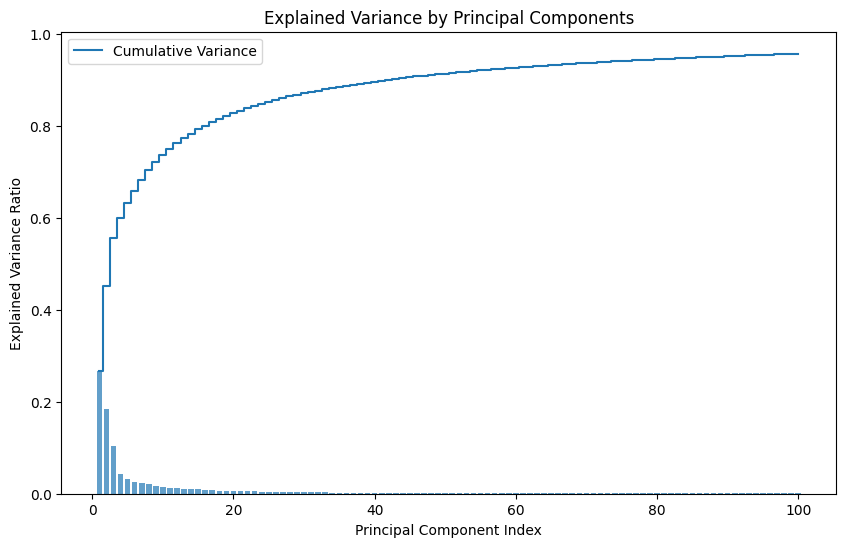

In [40]:
# Fit PCA and calculate explained variance
pca = PCA(n_components=100)  # Limit to 10 components for visualization
pca.fit(features_train_flat)
explained_variance = pca.explained_variance_ratio_

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center')
plt.step(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), where='mid', label='Cumulative Variance')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.legend(loc='best')
plt.show()
